In [1]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions

from MakeMyPrior.elicitation_wrapper import expert_model
from MakeMyPrior.training import trainer
from MakeMyPrior.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from MakeMyPrior.user_config import target_config, target_input
from MakeMyPrior.discrepancy_measures import energy_loss
from MakeMyPrior.helper_functions import print_restab, plot_priors_hyp, plot_expert_preds, group_stats
import MakeMyPrior.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

C:\Users\flobo\anaconda3\envs\make-my-prior\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# -.-|m { input: true, output_error: false, input_fold: show }

# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 600,                         
        epochs = 300,                      
        view_ep = 30,
        lr_decay = True,
        lr0 = 0.01, 
        lr_min = 0.0001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

In [3]:
# construct design matrix
X =  pa.dmatrix("a", pa.balanced(a = 3, repeat = 60), return_type="dataframe")
dmatrix = tf.cast(X, dtype = tf.float32)
# extract contrast matrix from design matrix (for allocating observations to groups)
cmatrix = dmatrix[0:dmatrix.shape[1], :]

print(X)

     Intercept  a[T.a2]  a[T.a3]
0          1.0      0.0      0.0
1          1.0      1.0      0.0
2          1.0      0.0      1.0
3          1.0      0.0      0.0
4          1.0      1.0      0.0
..         ...      ...      ...
175        1.0      1.0      0.0
176        1.0      0.0      1.0
177        1.0      0.0      0.0
178        1.0      1.0      0.0
179        1.0      0.0      1.0

[180 rows x 3 columns]


In [4]:
# true hyperparameter values for ideal_expert
true_values = dict()
true_values["mu"] = [1., 0.5, 1.5]
true_values["sigma"] = [0.8, 0.5, 0.5]
true_values["nu"] = 1.

# model parameters
parameters_dict = dict()
for i in range(3):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1)]*2
            }

exp_dist = Exponential_unconstrained(user_config["rep"])
parameters_dict["sigma"] = {
        "family": exp_dist,
        "true": exp_dist(tf.math.log(true_values["nu"])),
        "initialization": [tfd.Normal(0.,0.1)]
        }

print("True hyperparameter values:")
pp.pprint(true_values)

True hyperparameter values:
{'mu': [1.0, 0.5, 1.5], 'nu': 1.0, 'sigma': [0.8, 0.5, 0.5]}


In [5]:
# -.-|m { input: true, output_error: false, input_fold: show }

# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  
        
        # compute linear predictor term
        epred = parameters[:,:,0:3] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.expand_dims(parameters[:,:,-1], -1))
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        group_means = tf.reduce_mean(samples_grouped, axis = 2)
        
        return dict(likelihood = likelihood,          # obligatory: likelihood; callable
                    ypred = ypred,                    # obligatory: prior predictive data
                    epred = epred,                    # obligatory: samples from linear predictor
                    groups = samples_grouped,
                    group_means = group_means
                    )

In [6]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target = "group_means", 
                   elicitation = "quantiles", 
                   combine_loss = "by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t2 = target_config(target = "R2", 
                   elicitation = "histogram",
                   combine_loss = "all",
                   custom_target_function = custom_r2)

target_info = target_input(t1, t2)

pp.pprint(target_info)

{'combine_loss': ['by-group', 'all'],
 'custom_target_function': [None, <function custom_r2 at 0x0000025604FDD6C0>],
 'elicitation': ['quantiles', 'histogram'],
 'internal_loss': [None, None],
 'quantiles_specs': [(10, 20, 30, 40, 50, 60, 70, 80, 90)],
 'target': ['group_means', 'R2']}


In [7]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['group_means_quant_0', 'R2_hist_1'])

In [8]:
# group means
print(group_stats(prior_pred_res["ypred"], num_groups = 3))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 1.01 | 0.82 |
|  gr_1 | 1.49 | 0.94 |
|  gr_2 | 2.48 | 0.95 |
+-------+------+------+


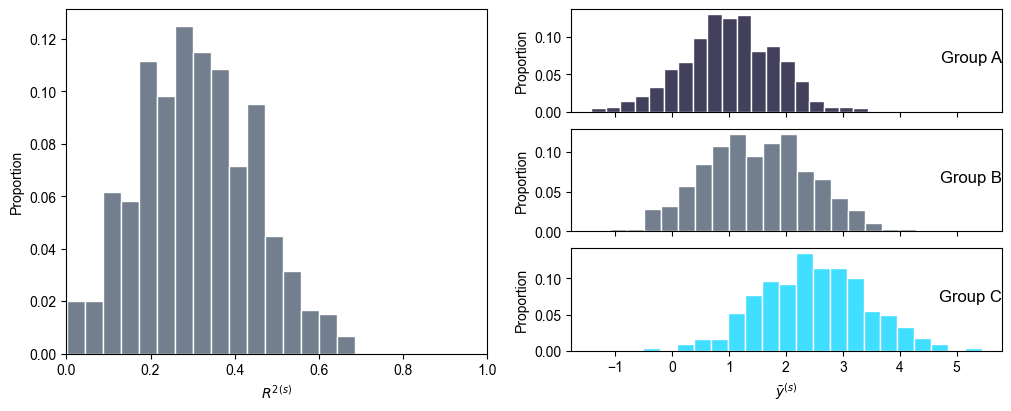

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

#_, axs = plt.subplots(1,2, constrained_layout = True, figsize = (6,3))
fig = plt.figure(layout='constrained', figsize=(10, 4))
figs = fig.subfigures(1,2)

axs0 = figs[0].subplots(1,1)
axs1 = figs[1].subplots(3,1, sharex = True)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.histplot(expert_res_list["R2_hist_1"][0,:], ax = axs0, stat = "proportion", color = "#44546A")
[sns.histplot(tf.reduce_mean(prior_pred_res["groups"], (0,2))[:,i], stat = "proportion",ax = axs1[i], color = c) for i,c in zip(range(3), ["#020024", "#44546A", "#00d4ff"])]
axs0.set_xlim(0,1)
axs0.set_xlabel(r"${R^2}^{(s)}$")
[axs1[i].set_title(f"Group {g}", loc = "right", y = 0.4) for i,g in zip(range(3), ["A","B","C"])]
axs1[2].set_xlabel(r"$\bar{y}^{(s)}$")
[axs1[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) for i in range(3)]
plt.show()

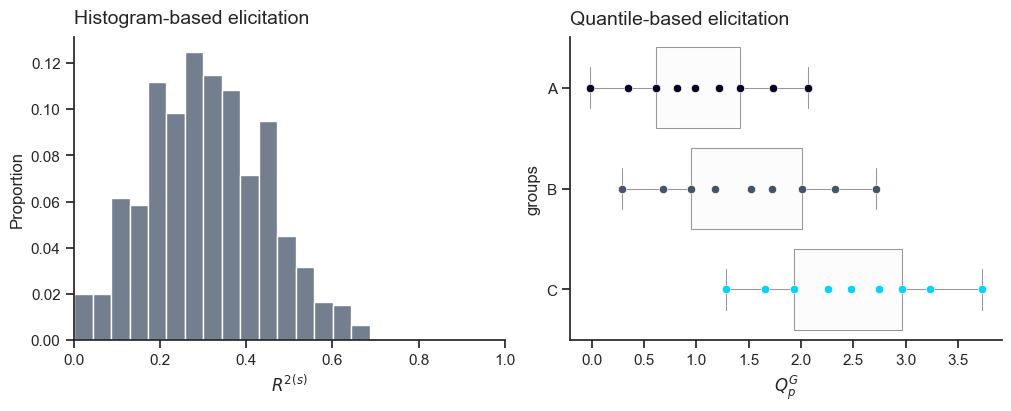

In [10]:
from statsmodels.graphics.boxplots import violinplot
import polars as pl

q_exp = expert_res_list["group_means_quant_0"]

df = pl.DataFrame( ) #, pl.Series("Group B", q_exp[1][0,:]), pl.Series("Group C", q_exp[2][0,:])) 
df = df.with_columns(
    q = np.arange(0.1,1., 0.1),
    A = pl.Series(q_exp[0][0,:].numpy()),
    B = pl.Series(q_exp[1][0,:].numpy()),
    C = pl.Series(q_exp[2][0,:].numpy())
)
df = df.melt(id_vars = "q", value_vars = ["A", "B", "C"], variable_name = "group")

df_pd = df.to_pandas()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, axs = plt.subplots(1,2, layout='constrained', figsize=(10, 4))
sns.histplot(expert_res_list["R2_hist_1"][0,:], ax = axs[0], stat = "proportion", color = "#44546A")
[sns.scatterplot(y = i, x = q_exp[i][0,:], color = c, ax = axs[1], zorder = 1) for i,c in zip(range(3), ["#020024", "#44546A", "#00d4ff"])]
sns.boxplot(x = df_pd["value"], y = df_pd["group"], color=".99",  linewidth=.75, zorder = 0) 
axs[0].set_xlim(0,1)
axs[0].set_xlabel(r"${R^2}^{(s)}$")
axs[1].set_ylabel("groups")
axs[1].set_xlabel("$Q_p^G$")
[axs[i].set_title(t, loc = "left", pad = 10., fontdict = {'fontsize': 14}) for i,t in zip(range(2), ["Histogram-based elicitation", "Quantile-based elicitation"])]
plt.show()

In [11]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 956.582ms
Epoch: 0, loss: 1.14150, lr: 0.010000
epoch_time: 128.154ms
Epoch: 30, loss: 0.69991, lr: 0.005314
epoch_time: 210.091ms
Epoch: 60, loss: 0.40157, lr: 0.002824
epoch_time: 134.428ms
Epoch: 90, loss: 0.27604, lr: 0.001501
epoch_time: 144.829ms
Epoch: 120, loss: 0.16257, lr: 0.000798
epoch_time: 133.859ms
Epoch: 150, loss: 0.05491, lr: 0.000424
epoch_time: 159.254ms
Epoch: 180, loss: 0.04135, lr: 0.000225
epoch_time: 190.132ms
Epoch: 210, loss: 0.03974, lr: 0.000120
epoch_time: 189.417ms
Epoch: 240, loss: 0.03967, lr: 0.000100
epoch_time: 134.632ms
Epoch: 270, loss: 0.03955, lr: 0.000100


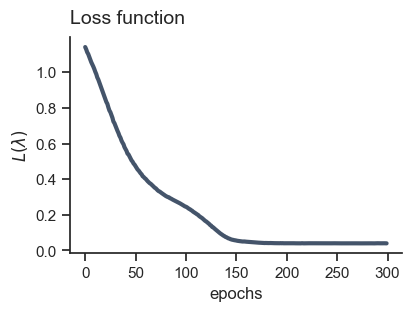

In [22]:
import matplotlib.pyplot as plt
import numpy as np

_, axs = plt.subplots(1,1, constrained_layout = True, figsize = (4,3))
axs.plot(np.arange(len(res_dict["loss_info"])), res_dict["loss_info"], color = "#44546A", lw = 3) 
axs.set_xlabel("epochs")
axs.set_ylabel(r"$L(\lambda)$")
axs.set_title("Loss function",pad = 10., fontdict = {'fontsize': 14}, loc = "left")
plt.show()

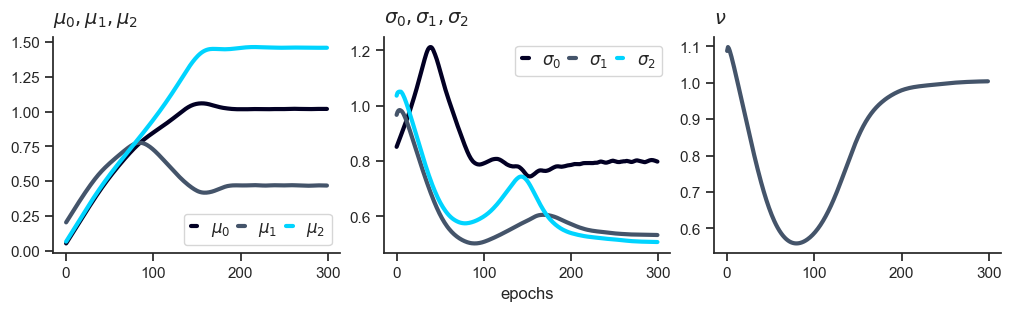

In [23]:
betas = tf.stack([res_dict["hyperparam_info"][0][i][0::2][:-1] for i in range(user_config["epochs"])], -1)
sigmas =  tf.stack([tf.exp(res_dict["hyperparam_info"][0][i][1::2]) for i in range(user_config["epochs"])], -1)
nu = tf.stack([tf.exp(res_dict["hyperparam_info"][0][i][-1]) for i in range(user_config["epochs"])], -1)

_, axs = plt.subplots(1,3, constrained_layout = True, figsize = (10,3), sharex = True)
[axs[0].plot(betas[i,:], lw = 3, color = c, label = fr"$\mu_{i}$") for i,c in zip(range(3), ["#020024", "#44546A", "#00d4ff"])]
[axs[1].plot(sigmas[i,:], lw = 3, color = c, label = fr"$\sigma_{i}$") for i,c in zip(range(3), ["#020024", "#44546A", "#00d4ff"])]
axs[2].plot(nu, lw = 3, color = "#44546A", label = "$\nu$") 
[axs[i].legend(handlelength = 0.4, fontsize = "medium", ncol = 3, columnspacing = 0.5) for i in range(2)]
axs[0].set_title(r"$\mu_0, \mu_1, \mu_2$",pad = 10., fontdict = {'fontsize': 14}, loc = "left")
axs[1].set_title(r"$\sigma_0, \sigma_1, \sigma_2$",pad = 10., fontdict = {'fontsize': 14}, loc = "left")
axs[2].set_title(r"$\nu$",pad = 10., fontdict = {'fontsize': 14}, loc = "left")
axs[1].set_xlabel("epochs")
plt.show()

In [14]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]
true_vals += [true_values["nu"]]

tab, avg_res = print_restab(method = "hyperparameter_learning", 
                             num_vars = 7, 
                             res = res_dict["hyperparam_info"], 
                             start = 10, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,1.019,0.0,1.0,0.019
scale_0,0.802,0.001,0.8,0.002
loc_1,0.47,0.0,0.5,0.03
scale_1,0.533,0.0,0.5,0.033
loc_2,1.457,0.0,1.5,0.043
scale_2,0.508,0.0,0.5,0.008
rate_3,1.004,0.0,1.0,0.004


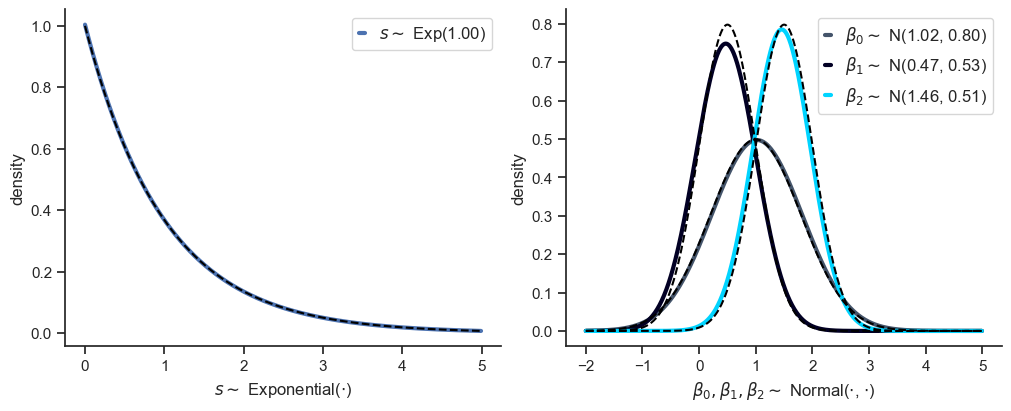

In [15]:
import seaborn as sns

cols = ["#020024", "#44546A", "#00d4ff"]
x = tf.range(-2.,5.,0.01)
x2 = tf.range(0., 5., 0.01)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, axs = plt.subplots(1,2, layout='constrained', figsize=(10, 4))
sns.lineplot(x=x,y=tfd.Normal(avg_res[0], avg_res[1]).prob(x), lw = 3, color = cols[1], ax = axs[1], label = rf"$\beta_0 \sim$ N({avg_res[0]:.2f}, {avg_res[1]:.2f})")
sns.lineplot(x=x,y=tfd.Normal(avg_res[2], avg_res[3]).prob(x), lw = 3, color = cols[0], ax = axs[1], label = rf"$\beta_1 \sim$ N({avg_res[2]:.2f}, {avg_res[3]:.2f})")
sns.lineplot(x=x,y=tfd.Normal(avg_res[4], avg_res[5]).prob(x), lw = 3, color = cols[2], ax = axs[1], label = rf"$\beta_2 \sim$ N({avg_res[4]:.2f}, {avg_res[5]:.2f})")
sns.lineplot(x=x2,y=tfd.Exponential(avg_res[6], force_probs_to_zero_outside_support=True).prob(x2), lw = 3, ax = axs[0], label = rf"$s \sim$ Exp({avg_res[6]:.2f})")
sns.lineplot(x=x,y=tfd.Normal(true_vals[0], true_vals[1]).prob(x), linestyle= "dashed", color = "black", ax = axs[1])
sns.lineplot(x=x,y=tfd.Normal(true_vals[2], true_vals[3]).prob(x), linestyle = "dashed", color = "black", ax = axs[1])
sns.lineplot(x=x,y=tfd.Normal(true_vals[4], true_vals[5]).prob(x), linestyle = "dashed", color = "black", ax = axs[1])
sns.lineplot(x=x2,y=tfd.Exponential(true_vals[6], force_probs_to_zero_outside_support=True).prob(x2), linestyle = "dashed", color = "black", ax = axs[0])
axs[0].set_xlabel(r"$s \sim$ Exponential($\cdot$)")
axs[1].set_xlabel(r"$\beta_0, \beta_1, \beta_2 \sim$ Normal($\cdot$, $\cdot$)")
[axs[i].set_ylabel("density") for i in range(2)]
[axs[i].legend(handlelength = 0.4, fontsize = "medium") for i in range(2)]
plt.show()

In [16]:
print(rf"$\beta_0 \sim$ Normal({avg_res[0]:.2f}, {avg_res[1]:.2f})")
print(f"b1 ~ Normal({avg_res[2]:.2f}, {avg_res[3]:.2f})")
print(f"b2 ~ Normal({avg_res[4]:.2f}, {avg_res[5]:.2f})")
print(f"s ~ Exponential({avg_res[6]:.2f})")

$\beta_0 \sim$ Normal(1.02, 0.80)
b1 ~ Normal(0.47, 0.53)
b2 ~ Normal(1.46, 0.51)
s ~ Exponential(1.00)
